# 프로젝트 핵심
이번 프로젝트 snow나 다른 사진 어플처럼 사진위에 부가적인 이미지를 추가하는 것입니다.
단순히 이것만 하면 그리 어렵지 않겠지만 얼굴 각도, 이미지 밝기, 촬영거리 등 원본 이미지를 적용했을 때 벌어지는 문제점들을 보완하는 과정이 핵심이고 가장 어려울 것 같습니다.

아마도 얼굴 각도나 촬영거리 등의 문제는 vector를 이용하여 계산을 해야할 것 같고 이미지 밝기는 불투명도를
조절해야할 것 같습니다.

코드를 하나 하나 쪼갰지만 맨 아래에 쪼개지 않고 합친 코드 또한 남기겠습니다.

필요한 라이브러리 import

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

print("🌫🛸")

🌫🛸


1.opencv로 이미지 부르기

2.opencv로 이미지 읽고 난 후 resize하기

3.출력용 이미지 보관


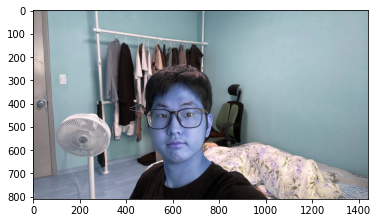

In [26]:

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)   

img_bgr_orig = img_bgr.copy()
img_show = img_bgr.copy()      
plt.imshow(img_bgr)
plt.show()

RGB변환

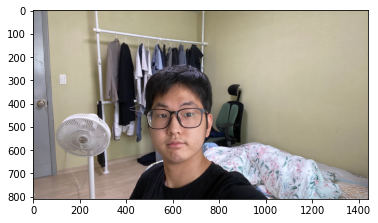

In [4]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


HOG Detector 선언하기(매칭 특징 검출)

In [6]:
detector_hog = dlib.get_frontal_face_detector()

In [ ]:
Bounding box 가져오기

In [7]:
dlib_rects = detector_hog(img_rgb, 1)  

찾는 얼굴 영역의 좌표

rectangles[[(498, 379) (765, 647)]]


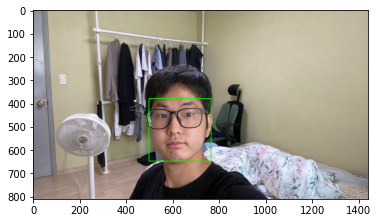

In [8]:
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

landmark model 부르기

In [9]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


landmark 찾기 및 개수 확인

In [11]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0]))

68


landmark출력

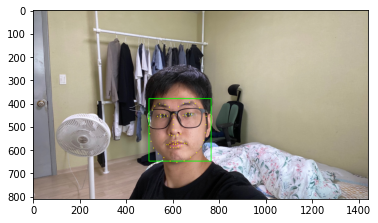

In [12]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

좌표 확인

In [76]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = landmark[14][0]-landmark[2][0]
    h = landmark[40][1] - landmark[35][1]
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(602, 513)
(x,y) : (602,513)
(w,h) : (238,-73)


스티커  이미지 Read

In [77]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show


error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/imgproc/src/resize.cpp:4054: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'


스티커 이미지 좌표

In [70]:
refined_x = x - w // 2  
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (468,379)


y좌표가 음수일 때, -y만큼 자른 후 경계값 0

In [71]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(268, 268, 3)
(x,y) : (468,379)


원본에 스티커 적용

In [72]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

결과 이미지 출력

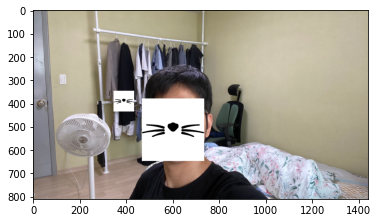

In [73]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

불투명도 조절

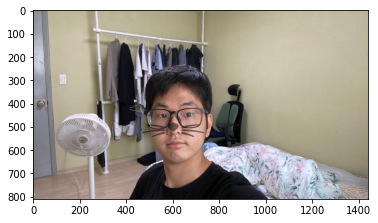

In [61]:
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

vector계산

In [21]:
landmark = list_landmarks[0]
v1 = np.array([0, -1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)


회전 변환

<function matplotlib.pyplot.show(close=None, block=None)>

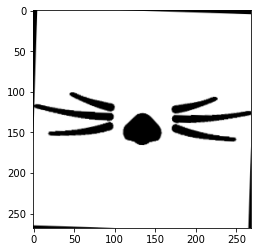

In [22]:
rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(angle), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

회전 후 불투명도 조절..허나 실패

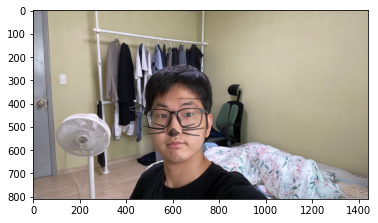

In [23]:
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 회고

1번 과 2번을 수행하는 것에 있어서는 익스의 예제들을 인지하고 어떤 경우에 쓰이는 지만 안다면 푸는데 어려움은 없었다. 허나 문제는 3번이었습니다 당연히 얼굴의 각도나 밝기 , 촬영거리 등등으로 인해 얼굴의 선이나 이목구비들을 제대로 측정하기가 어려워지고 이로 인해  변해지는 좌표의 값들을 유기적으로 대체를 하지 못한다면 얼굴에 스티커 이미지가 제대로 들어가지 못해서 스티커 앱으로서 기능을 못할 것입니다. 그래서 생각해 낸 개념이 벡터입니다. 벡터는 무한히 증가하고 유동성이 있기 때문에 좌표들이 변하더라도 대처를 잘 할 것 같기 때문에 위의 문제점을 해결할 수 있을 것 같습니다. 허나 실제로 벡터로 계산을 해보고 회전도 시켰지만 막상 해보니 회전까지는 시켰지만 회전 후에 불투명도를 조절하진 못했습니다. 그 이유는 아마 회전을 할 때 어느 벡터를 기준으로 회전을 해야하는지 명확히 알지 못해서 벌인 헤프닝 같습니다.
무튼 저는 벡터를 어떻게 하면 실생활에 잘 쓰이고 스티커 앱들이 어떻게 벡터를 잡고 구현하는지에 대해서 공부를 하고 싶어졌습니다.

한 번에 나열한 코드입니다.

(나중에 개발자가 되면 이렇게 한 번에 나열하고 싶습니다.)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

print("🌫🛸")


my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/images01.jpg'
img_bgr = cv2.imread(my_image_path)    

img_bgr_orig = img_bgr.copy()
img_show = img_bgr.copy()     
plt.imshow(img_bgr)
plt.show()


img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


detector_hog = dlib.get_frontal_face_detector()


dlib_rects = detector_hog(img_rgb, 1)   


print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)


refined_x = x - w // 2  
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

 
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


landmark = list_landmarks[0]
v1 = np.array([0, -1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(angle), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()